# **RAG system with Qdrant and Langtrace**

This notebook demonstrates how to implement a Retrieval-Augmented Generation (RAG) system using Qdrant as the vector database and Langtrace for tracing operations.

### **Preqs:**
* Sign-up for a free account on [Langtrace](https://langtrace.ai).
* Create a project then generate an API key. Refer to [quickstart documentation](https://docs.langtrace.ai/quickstart) for help.
* (Optionally)Sign-up for a free [Qdrant Cloud](https://cloud.qdrant.io/login)
* You will also need an OpenAI API Key

#### **Install the required libraries**

In [1]:
#pip install -Uq qdrant-client openai fastembed langtrace-python-sdk python-dotenv


#### **Setup**

First, let's import the necessary libraries and initialize our clients. Be sure to update your OpenAI API Key and Langtrace API Key:

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
import time
import openai
import qdrant_client
from langtrace_python_sdk import langtrace, with_langtrace_root_span
from typing import List, Dict, Any

# Initialize environment and clients
#os.environ["OPENAI_API_KEY"] = "your_openai_key"  # Replace with your actual OpenAI API key
langtrace.init(api_key=os.environ["LANGTRACE_API_KEY"])  # Replace with your actual Langtrace API key in env file
openai_client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

Initializing Langtrace SDK..
Exporting spans to Langtrace cloud..
Exported 2 spans successfully.
Exported 2 spans successfully.
Exported 10 spans successfully.
Exported 9 spans successfully.
Exported 21 spans successfully.


In [4]:
## Collection Name - that will be used thoroughout the notebook
COLLECTION_NAME = "knowledge-base-langtrace"

#### **Connecting to Qdrant Vector Database**

Qdrant is a vector database designed for efficient storage and retrieval of high-dimensional vectors.
It is ideal for use cases like RAG, where retrieving relevant information quickly is crucial.
We can use Qdrant in 3 different listed ways, we are using [Qdrant Cloud](https://cloud.qdrant.io/login) in this workshop today.

In [5]:
##Uncomment to initialise qdrant client in memory
#client = qdrant_client.QdrantClient(
#    location=":memory:",
#)

##Uncomment below to connect to Qdrant Cloud
client = qdrant_client.QdrantClient(
    os.environ.get("QDRANT_URL"),
    api_key=os.environ.get("QDRANT_API_KEY"),
)

## Uncomment below to connect to local Qdrant
#client = qdrant_client.QdrantClient("http://localhost:6333")

print("Setup complete!")

Setup complete!


### **Implementing RAG Components**

Now, let's implement the core components of our RAG system:

In [9]:
@with_langtrace_root_span("initialize_knowledge_base")
def initialize_knowledge_base(documents: List[str]) -> None:
    client.add(
        collection_name=COLLECTION_NAME,
        documents=documents
    )
    print(f"Knowledge base initialized with {len(documents)} documents ")

@with_langtrace_root_span("query_vector_db")
def query_vector_db(question: str, n_points: int = 3) -> List[Dict[str, Any]]:
    results = client.query(
        collection_name=COLLECTION_NAME,
        query_text=question,
        limit=n_points,
    )
    print(f"Vector DB queried, returned {len(results)} results")
    return results

@with_langtrace_root_span("generate_llm_response")
def generate_llm_response(prompt: str, model: str = "gpt-3.5-turbo") -> str:
    completion = openai_client.chat.completions.create(
        model=model,
        messages=[
            {"role": "user", "content": prompt},
        ],
        timeout=10.0,
    )
    response = completion.choices[0].message.content
    print(f"LLM response generated")
    return response

@with_langtrace_root_span("rag")
def rag(question: str, n_points: int = 3) -> str:
    print(f"Processing RAG for question: {question}")
    
    results = query_vector_db(question, n_points)
    context = "\n".join([r.document for r in results]) if results else "No relevant information found."
    print(f"Context retrieved")
    
    metaprompt = f"""
    You are a software architect.
    Answer the following question using the provided context.
    If you can't find the answer in the context, respond with "I don't have enough information to answer this question."

    Question: {question.strip()}

    Context:
    {context.strip()}

    Answer:
    """
    print(f"Prompt constructed")
    
    answer = generate_llm_response(metaprompt)
    print(f"RAG completed, answer length: {len(answer)} characters")
    return answer

print("RAG components defined!")

RAG components defined!


### **Initializing the Knowledge Base**

Let's initialize our knowledge base with some sample documents:

In [7]:
documents = [
    "Qdrant is a vector database & vector similarity search engine. It deploys as an API service providing search for the nearest high-dimensional vectors. With Qdrant, embeddings or neural network encoders can be turned into full-fledged applications for matching, searching, recommending, and much more!",
    "Docker helps developers build, share, and run applications anywhere — without tedious environment configuration or management.",
    "PyTorch is a machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing.",
    "MySQL is an open-source relational database management system (RDBMS). A relational database organizes data into one or more data tables in which data may be related to each other; these relations help structure the data. SQL is a language that programmers use to create, modify and extract data from the relational database, as well as control user access to the database.",
    "NGINX is a free, open-source, high-performance HTTP server and reverse proxy, as well as an IMAP/POP3 proxy server. NGINX is known for its high performance, stability, rich feature set, simple configuration, and low resource consumption.",
    "FastAPI is a modern, fast (high-performance), web framework for building APIs with Python 3.7+ based on standard Python type hints.",
    "SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. You can use this framework to compute sentence / text embeddings for more than 100 languages. These embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining.",
    "The cron command-line utility is a job scheduler on Unix-like operating systems. Users who set up and maintain software environments use cron to schedule jobs (commands or shell scripts), also known as cron jobs, to run periodically at fixed times, dates, or intervals.",
]

initialize_knowledge_base(documents)

100%|████████████████████████████████████████████████████████████████████████| 77.7M/77.7M [00:07<00:00, 9.94MiB/s]


Knowledge base initialized with 8 documents 


### **Testing the RAG System**

Now, let's test our RAG system with a few sample questions:

In [10]:
def demonstrate_different_queries():
    questions = [
        "What is Qdrant used for?",
        "How does Docker help developers?",
        "What is the purpose of MySQL?",
        "Can you explain what FastAPI is?",
        "What is FIFPRO Award?"
    ]
    for question in questions:
        try:
            answer = rag(question)
            print(f"Question: {question}")
            print(f"Answer: {answer}\n")
        except Exception as e:
            print(f"Error processing question '{question}': {str(e)}\n")

demonstrate_different_queries()

Processing RAG for question: What is Qdrant used for?
Vector DB queried, returned 3 results
Context retrieved
Prompt constructed


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


LLM response generated
RAG completed, answer length: 80 characters
Question: What is Qdrant used for?
Answer: Qdrant is used for vector database and vector similarity search engine purposes.

Processing RAG for question: How does Docker help developers?
Vector DB queried, returned 3 results
Context retrieved
Prompt constructed
LLM response generated
RAG completed, answer length: 298 characters
Question: How does Docker help developers?
Answer: Docker helps developers by providing a platform where they can build, share, and run applications without the need for manual environment configuration or management. This allows developers to easily create and deploy applications in a consistent manner without worrying about compatibility issues.

Processing RAG for question: What is the purpose of MySQL?
Vector DB queried, returned 3 results
Context retrieved
Prompt constructed
LLM response generated
RAG completed, answer length: 203 characters
Question: What is the purpose of MySQL?
Answer: Th

### **Analyzing Traces**

After running our RAG system, we can analyze the traces in the [Langtrace dashboard](https://langtrace.ai/projects). 

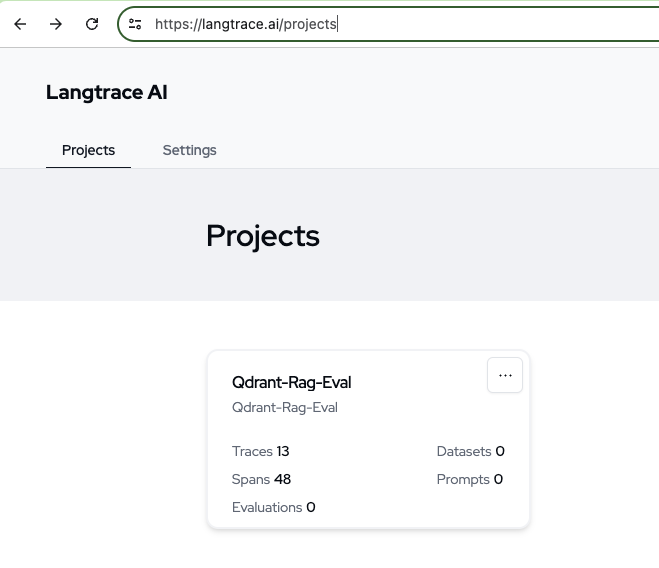

Here's what to look for:

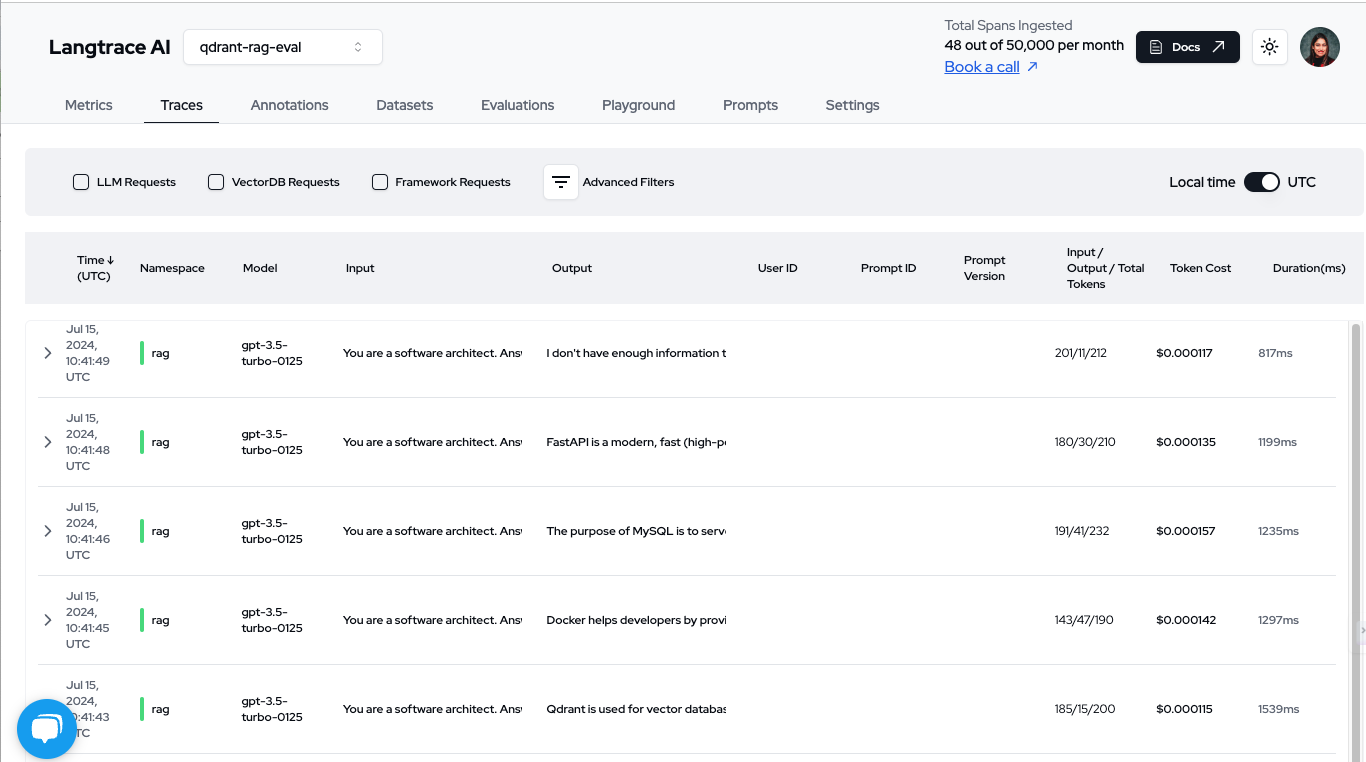

You can observe the `Total Tokens` , `Token Cost` and `Duration(Latency)`.

You can also select to debug `LLM Requests` , `VectorDB Requests` and `Framework Requests` for further visibility.

You can navigate each trace to find out more information as below :


![Alt text](./assets/langtraceqdrant.png "a trace view in Langtrace")

You can add `Advanced Filters` and debug them further as applicable : 

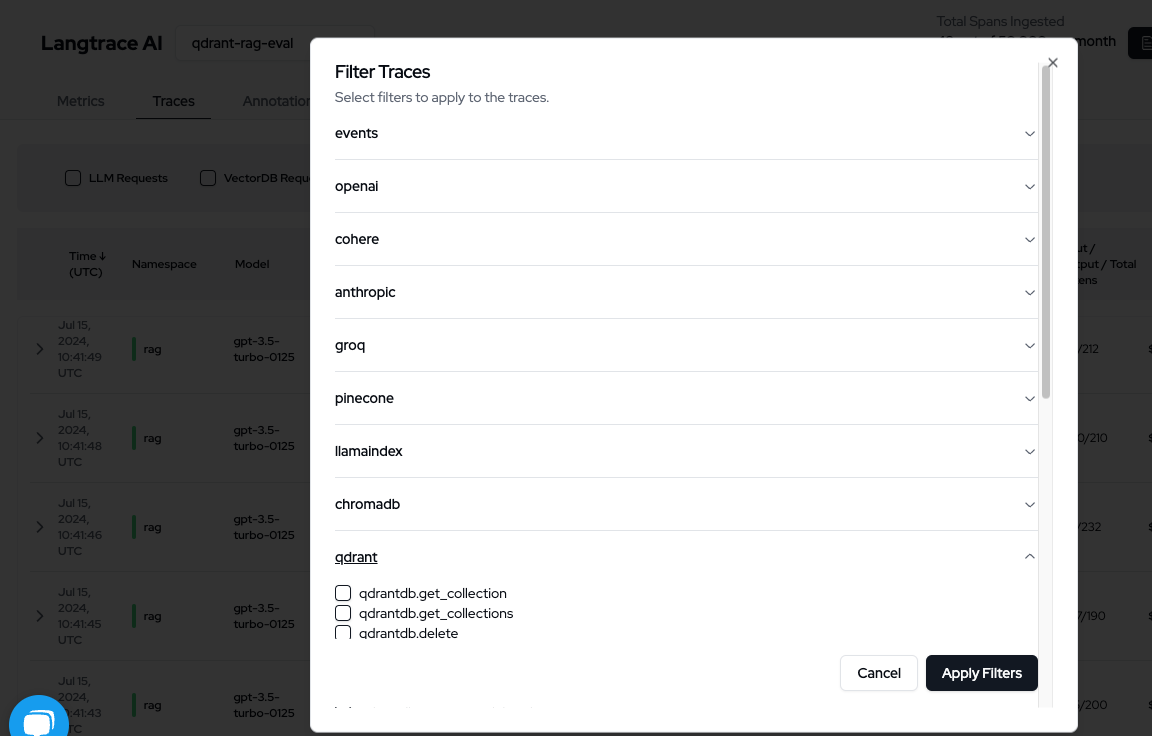

**In Sum**
<br>
Process of analyzing traces as below : 
1. Check the [`Langtrace dashboard`](https://langtrace.ai/projects) for a visual representation of the traces.
2. Look for the `rag` root span and its child spans to understand the flow.
3. Examine the timing information shown for each operation to `identify potential bottlenecks`.
4. Review any `error messages` printed to understand and address issues.
5. Pay attention to questions like `What is FIFPRO Award?` to see how the system handles queries `without relevant information in the knowledge base`.
